In [23]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Least squares and linear basis functions models
## Least squares

In [24]:
def compute_loss(y, tx, w, mae = False):
    """Calculate the loss.

    You can calculate the loss using mse or mae.
    """
    loss = 0
    N = y.shape[0]
    e = y-np.dot(tx,w)
    
    if mae:
        loss = 1/N * np.sum(np.absolute(e))
    else:
        loss = 1/(2*N) * (np.dot(np.transpose(e),e))

    return loss


In [25]:
def least_squares(y, tx):
    w = np.linalg.pinv(tx).dot(y) # np.linalg.inv(tx.T.dot(tx)).dot(tx.T).dot(y)
    #return w, compute_loss(y, tx, w)
    return w, compute_loss(y, tx, w)

### Load the data
Here we will reuse the dataset `height_weight_genders.csv` from previous exercise section to check the correctness of your implementation. Please compare it with your previous result.

In [26]:
def grid_search(y, tx, w0, w1):
    """Algorithm for grid search."""
    losses = np.zeros((len(w0), len(w1)))
    for idx, i in enumerate(w0):
        for idx2, j in enumerate(w1):
            losses[idx][idx2] = compute_loss(y, tx, [i,j])
    return losses

In [27]:
def compute_gradient(y, tx, w):
    """Compute the gradient."""
    N = y.shape[0]
    e = y-np.dot(tx,w)
    
    return -1/N * np.dot(np.transpose(tx), e)

def gradient_descent(y, tx, initial_w, max_iters, gamma): 
    """Gradient descent algorithm."""
    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w
    for n_iter in range(max_iters):
        grad = compute_gradient(y, tx, w)
        loss = compute_loss(y, tx, w)
        w = w - gamma * grad
        # store w and loss
        ws.append(np.copy(w))
        losses.append(loss)
        print("Gradient Descent({bi}/{ti}): loss={l}, w0={w0}, w1={w1}".format(
              bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]))

    return losses, ws

In [28]:
from helpers import *
from grid_search import generate_w, get_best_parameters

def test_your_least_squares():
    height, weight, gender = load_data_from_ex02(sub_sample=False, add_outlier=False)
    x, mean_x, std_x = standardize(height)
    y, tx = build_model_data(x, weight)
    
    w, losses = least_squares(y, tx)
    
    grid_w0, grid_w1 = generate_w(num_intervals=200)
    grid_losses = grid_search(y, tx, grid_w0, grid_w1)
    
    max_iters = 50
    gamma = 0.4

    # Initialization
    w_initial = np.array([0.0, 0.0])

    # Start gradient descent.
    gradient_losses, gradient_ws = gradient_descent(y, tx, w_initial, max_iters, gamma)
    print("Least square lost: ", losses, ", w0=", w[0], ", w1=", w[1])
    

test_your_least_squares()

Gradient Descent(0/49): loss=2792.2367127591665, w0=29.317568800842015, w1=5.391884973995655
Gradient Descent(1/49): loss=1015.0521848293532, w0=46.90811008134726, w1=8.627015958393002
Gradient Descent(2/49): loss=375.26575477461887, w0=57.46243484965045, w1=10.568094549031404
Gradient Descent(3/49): loss=144.94263995491326, w0=63.79502971063234, w1=11.732741703414456
Gradient Descent(4/49): loss=62.026318619819655, w0=67.59458662722147, w1=12.431529996044297
Gradient Descent(5/49): loss=32.176442939185925, w0=69.87432077717496, w1=12.85080297162219
Gradient Descent(6/49): loss=21.43048769415777, w0=71.24216126714705, w1=13.10236675696893
Gradient Descent(7/49): loss=17.5619438059476, w0=72.06286556113031, w1=13.253305028176976
Gradient Descent(8/49): loss=16.169268006191956, w0=72.55528813752026, w1=13.343867990901805
Gradient Descent(9/49): loss=15.667904718279921, w0=72.85074168335424, w1=13.398205768536702
Gradient Descent(10/49): loss=15.487413934631583, w0=73.02801381085462, w1=1

## Least squares with a linear basis function model
Start from this section, we will use the dataset `dataEx3.csv`.

### Implement polynomial basis functions

In [29]:
# load dataset
x, y = load_data()
print("shape of x {}".format(x.shape))
print("shape of y {}".format(y.shape))

shape of x (50,)
shape of y (50,)


In [30]:
def build_poly(x, degree):
    """polynomial basis functions for input data x, for j=0 up to j=degree."""
    return np.array([[line**deg for deg in range(degree+1)] for line in x])

Let us play with polynomial regression. Note that we will use your implemented function `compute_mse`. Please copy and paste your implementation from exercise02.

Processing 1th experiment, degree=1, rmse=0.47187607963421874
Processing 2th experiment, degree=3, rmse=0.25858277667737506
Processing 3th experiment, degree=7, rmse=0.24965870360907552
Processing 4th experiment, degree=12, rmse=0.2403250746517712


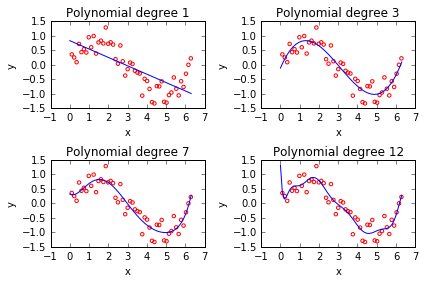

In [31]:
from plots import *

def polynomial_regression():
    """Constructing the polynomial basis function expansion of the data,
       and then running least squares regression."""
    # define parameters
    degrees = [1, 3, 7, 12]
    
    # define the structure of figure
    num_row = 2
    num_col = 2
    f, axs = plt.subplots(num_row, num_col)

    for ind, degree in enumerate(degrees):
        basis = build_poly(x, degree)
        weight, losses = least_squares(y, basis)
        rmse = np.sqrt(2*compute_loss(y, basis, weight))

        print("Processing {i}th experiment, degree={d}, rmse={loss}".format(
              i=ind + 1, d=degree, loss=rmse))
        # plot fit
        plot_fitted_curve(
            y, x, weight, degree, axs[ind // num_col][ind % num_col])
    plt.tight_layout()
    plt.savefig("visualize_polynomial_regression")
    plt.show()


polynomial_regression()

# Evaluating model predication performance

Let us show the train and test splits for various polynomial degrees. First of all, please fill in the function `split_data()`

In [32]:
def split_data(x, y, ratio, seed=1):
    """split the dataset based on the split ratio."""
    # set seed
    np.random.seed(seed)
    indices = np.arange(x.shape[0])
    np.random.shuffle(indices)
    # np.random.permutation

    number = int(x.shape[0]*ratio)
    trainingX = np.array([x[i] for i in indices[:number]])
    trainingY = np.array([y[i] for i in indices[:number]])

    testX = np.array([x[i] for i in indices[number:]])
    testY = np.array([y[i] for i in indices[number:]])
    assert(trainingX.shape[0] + testX.shape[0] == x.shape[0])
    
    return trainingX, trainingY, testX, testY
    


Then, test your `split_data` function below.

In [33]:
def train_test_split_demo(x, y, degree, ratio, seed):
    """polynomial regression with different split ratios and different degrees."""
    trainX, trainY, testX, testY = split_data(x, y, ratio, seed)
   
    trainPoly = build_poly(trainX, degree)
    testPoly = build_poly(testX, degree)
    
    weight, losses = least_squares(trainY, trainPoly)
    
    rmse_tr = np.sqrt(2*compute_loss(trainY, trainPoly, weight))
    rmse_te = np.sqrt(2*compute_loss(testY, testPoly, weight))

    
    print("proportion={p}, degree={d}, Training RMSE={tr:.3f}, Testing RMSE={te:.3f}".format(
          p=ratio, d=degree, tr=rmse_tr, te=rmse_te))

seed = 6
degrees = [1, 3, 7, 12]
split_ratios = [0.9, 0.5, 0.1]

for split_ratio in split_ratios:
    for degree in degrees:
        train_test_split_demo(x, y, degree, split_ratio, seed)

proportion=0.9, degree=1, Training RMSE=0.494, Testing RMSE=0.181
proportion=0.9, degree=3, Training RMSE=0.264, Testing RMSE=0.206
proportion=0.9, degree=7, Training RMSE=0.254, Testing RMSE=0.220
proportion=0.9, degree=12, Training RMSE=0.242, Testing RMSE=0.250
proportion=0.5, degree=1, Training RMSE=0.455, Testing RMSE=0.531
proportion=0.5, degree=3, Training RMSE=0.239, Testing RMSE=0.296
proportion=0.5, degree=7, Training RMSE=0.232, Testing RMSE=0.284
proportion=0.5, degree=12, Training RMSE=0.205, Testing RMSE=1.065
proportion=0.1, degree=1, Training RMSE=0.428, Testing RMSE=0.534
proportion=0.1, degree=3, Training RMSE=0.085, Testing RMSE=0.460
proportion=0.1, degree=7, Training RMSE=0.000, Testing RMSE=2.202
proportion=0.1, degree=12, Training RMSE=0.000, Testing RMSE=10.218


# Ridge Regression
Please fill in the function below.

In [34]:
def ridge_regression(y, tx, lamb):
    """implement ridge regression."""
    ident = np.eye(tx.shape[1])*lamb
    return np.linalg.inv(tx.T.dot(tx)+ident).dot(tx.T).dot(y)


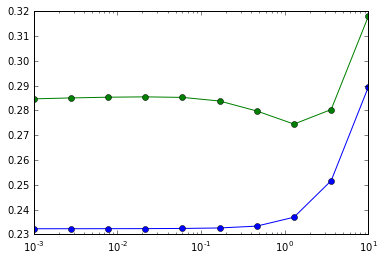

In [35]:
### import matplotlib.pyplot as plt
def ridge_regression_demo(x, y, degree, ratio, seed):
    """ridge regression demo."""
    # define parameter
    lambdas = np.logspace(-3, 1, 10) 
   
    trainX, trainY, testX, testY = split_data(x, y, ratio, seed)
    trainPoly = build_poly(trainX, degree)
    testPoly = build_poly(testX, degree)

    
    errorsTR = []
    errorsTE = []
    
    for lam in lambdas:
        w = ridge_regression(trainY, trainPoly, lam)
        rmse_tr = np.sqrt(2*compute_loss(trainY, trainPoly, w))
        rmse_te = np.sqrt(2*compute_loss(testY, testPoly, w))
        
       # print("Training:", rmse_tr, "Testing:",rmse_te)
        
        errorsTR.append(rmse_tr)
        errorsTE.append(rmse_te)
        
    plt.semilogx(lambdas, errorsTR, '-o', lambdas, errorsTE,'-o', lw=1)
    plt.show()   
    
seed = 6
degree = 7
split_ratio = 0.5
  
ridge_regression_demo(x, y, degree, split_ratio, seed)